In [11]:
import re
 
log_file_path = "identity.log"
regex_hls = r"(\(identity_hls:sink\)) (\(.*?\))"
regex_tp = r"(\(identity_tp:sink\)) (\(.*?\))"
regex_pay = r"(\(identity_pay:sink\)) (\(.*?\))"

identity_hls = []
identity_tp=[]
identity_pay=[]
with open(log_file_path, "r") as file:
    for line in file:
        #import pdb; pdb.set_trace() 
        for match in re.finditer(regex_hls, line, re.S):
            item={}
            for i in match.group(2).split(',')[1:6]:
                item[i.split(':')[0].strip()]=i.split(':')[1].strip()
            identity_hls.append(item)
        for match in re.finditer(regex_tp, line, re.S):
            item={}
            for i in match.group(2).split(',')[1:6]:
                item[i.split(':')[0].strip()]=i.split(':',1)[1].strip()
            identity_tp.append(item)
        for match in re.finditer(regex_pay, line, re.S):
            item={}
            for i in match.group(2).split(',')[1:6]:
                item[i.split(':')[0].strip()]=i.split(':',1)[1].strip()
            identity_pay.append(item)

print("size of identity_hls:{0}".format(len(identity_hls)))
print("Size of identity_tp:{0}".format(len(identity_tp)))
print("size of identity_pay:{0}".format(len(identity_pay)))

Size of identity_tp:28893
size of identity_hls:3
size of identity_pay:5905


In [12]:
#Check offset continuity on the output of HLSDemux
for index, i_hls in enumerate(identity_hls[0:-1]):
    if int(identity_hls[index]['offset_end']) != int(identity_hls[index+1]['offset']) :
        print("Offset continuity error at index:%i",index)
        print index,identity_hls[index]
        print index+1,identity_hls[index+1]

('Offset continuity error at index:%i', 0)
0 {'dts': 'none', 'duration': 'none', 'pts': '0', 'offset_end': '6916896', 'offset': '0'}
1 {'dts': 'none', 'duration': 'none', 'pts': '0', 'offset_end': '6916896', 'offset': '0'}
('Offset continuity error at index:%i', 1)
1 {'dts': 'none', 'duration': 'none', 'pts': '0', 'offset_end': '6916896', 'offset': '0'}
2 {'dts': 'none', 'duration': 'none', 'pts': 'none', 'offset_end': '6955060', 'offset': '0'}


In [13]:
#Check offset continuity on the output of TSParse
for index, i_tp in enumerate(identity_tp[0:-1]):
    if int(identity_tp[index]['offset_end']) != int(identity_tp[index+1]['offset']) :
        print("Offset continuity error at index:%i",index)
        print index,identity_tp[index]
        print index+1,identity_tp[index+1]

In [15]:
#Check timestamp continuity
def to_ns(str):
    tag=re.split('[:.]',str)
    return int(tag[0])*60*60*1000000000+ \
            int(tag[1])*60*1000000000+ \
            int(tag[2])*1000000000+ \
            int(tag[3])
            
for index,i_tp in enumerate(identity_tp[0:-1]):
    if (to_ns(identity_tp[index]["pts"])+to_ns(identity_tp[index]["duration"])) > to_ns(identity_tp[index+1]["pts"]):
        print("Timestamp continuity error at %i",index)
        print(index,identity_tp[index]["pts"],identity_tp[index]["duration"])
        print(index+1,identity_tp[index+1]["pts"],identity_tp[index+1]["duration"])                        
                                                                                              

ValueError: invalid literal for int() with base 10: 'none'

In [16]:
from __future__ import division # floating point division in Py2x
pts=[to_ns(i["pts"])/1000000000 for i in identity_tp]
duration=[ to_ns(i["duration"])  for i in identity_tp]
segsize=[ int(i["offset_end"])-int(i["offset"]) for i in identity_tp]
bitrate=[s*8/(d/1000) for s,d in zip(segsize,duration)] 

ValueError: invalid literal for int() with base 10: 'none'

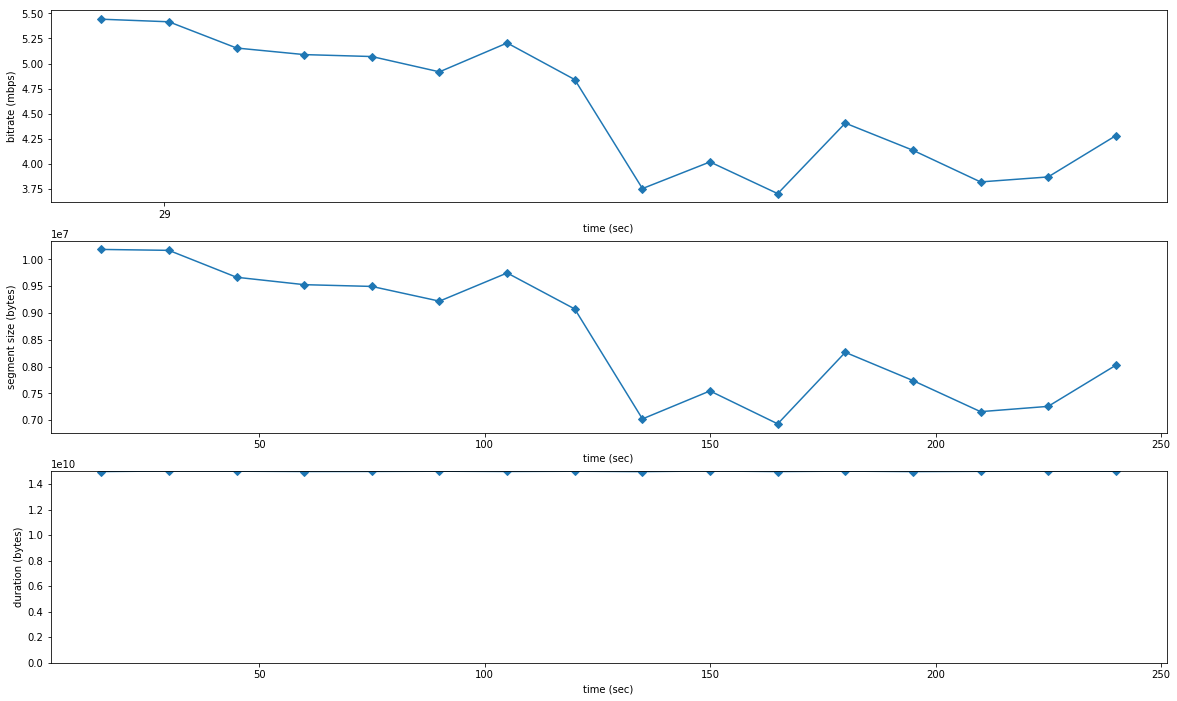

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline  
bounds=(0,len(identity_tp))
#bounds=(1400,1600)
plt.rcParams["figure.figsize"] = (20,12)
plt.figure()
plt.ylim(bottom=0);
plt.subplot(311);
plt.xticks([29]);
#plt.plot(pts[bounds[0]:bounds[1]],bitrate[bounds[0]:bounds[1]],'-D',markevery=[30]);
plt.plot(pts[bounds[0]:bounds[1]],bitrate[bounds[0]:bounds[1]],'-D');
plt.xlabel("time (sec)");
plt.ylabel("bitrate (mbps)");
plt.subplot(312);
plt.plot(pts[bounds[0]:bounds[1]],segsize[bounds[0]:bounds[1]],'-D');
plt.xlabel("time (sec)");
plt.ylabel("segment size (bytes)");
plt.subplot(313);
plt.plot(pts[bounds[0]:bounds[1]],duration[bounds[0]:bounds[1]],'-D');
plt.xlabel("time (sec)");
plt.ylabel("duration (bytes)");
plt.ylim(bottom=0);

In [135]:
# Lets find bad segments....
for index,b in enumerate(bitrate):
    if b>15:
        print("****************")
        print(index-1, identity_tp[index-1],"Bitrate:{0:.2f} mbps, Segment size:{1} bytes".format(bitrate[index-1],segsize[index-1]))
        print(index, identity_tp[index],"Bitrate:{0:.2f} mbps, Segment size:{1} bytes".format(b,segsize[index]))
        print(index+1, identity_tp[index+1],"Bitrate:{0:.2f} mbps, Segment size:{1} bytes".format(bitrate[index+1],segsize[index+1]))
        

****************
(392, {'dts': '0:00:24.938199740', 'duration': '0:00:00.035161440', 'pts': '0:00:24.938199740', 'offset_end': '6796331', 'offset': '6761859'}, 'Bitrate:7.84 mbps, Segment size:34472 bytes')
(393, {'dts': '0:00:24.973393852', 'duration': '0:00:00.005523456', 'pts': '0:00:24.973393852', 'offset_end': '6817907', 'offset': '6796331'}, 'Bitrate:31.25 mbps, Segment size:21576 bytes')
(394, {'dts': '0:00:24.978919629', 'duration': '0:00:00.035332576', 'pts': '0:00:24.978919629', 'offset_end': '6831939', 'offset': '6817907'}, 'Bitrate:3.18 mbps, Segment size:14032 bytes')
****************
(491, {'dts': '0:00:27.697234778', 'duration': '0:00:00.035254008', 'pts': '0:00:27.697234778', 'offset_end': '8610219', 'offset': '8593875'}, 'Bitrate:3.71 mbps, Segment size:16344 bytes')
(492, {'dts': '0:00:27.732501222', 'duration': '0:00:00.005718792', 'pts': '0:00:27.732501222', 'offset_end': '8634147', 'offset': '8610219'}, 'Bitrate:33.47 mbps, Segment size:23928 bytes')
(493, {'dts': 